In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn
import os
import cartopy.crs as ccrs

In [2]:
# get patbs
path_code = %pwd
os.chdir("..")
path_input = os.path.join(os.path.abspath(os.curdir),'_raw')

In [3]:
# create an xarray data array from the raw netcdf file
da = xr.open_dataarray(os.path.join(path_input,'GEBCO_2014_2D.nc'));da

<xarray.DataArray 'elevation' (lat: 21600, lon: 43200)>
[933120000 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.99 -89.98 -89.97 -89.96 -89.95 -89.95 ...
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 -180.0 -180.0 -179.9 ...
Attributes:
    standard_name:       height_above_reference_ellipsoid
    long_name:           Elevation relative to sea level
    units:               m
    sdn_parameter_urn:   SDN:P01::BATHHGHT
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_uom_urn:         SDN:P06:ULAA
    sdn_uom_name:        Metres

In [4]:
# check latitudes values (could have checked longitude values) look reasonable
da.lat

<xarray.DataArray 'lat' (lat: 21600)>
array([-89.995833, -89.9875  , -89.979167, ...,  89.979167,  89.9875  ,
        89.995833])
Coordinates:
  * lat      (lat) float64 -90.0 -89.99 -89.98 -89.97 -89.96 -89.95 -89.95 ...
Attributes:
    standard_name:       latitude
    long_name:           latitude
    units:               degrees_north
    axis:                Y
    sdn_parameter_urn:   SDN:P01::ALATZZ01
    sdn_parameter_name:  Latitude north
    sdn_uom_urn:         SDN:P06:DEGN
    sdn_uom_name:        Degrees north

In [5]:
# spatially subset the data for plotting (it's a big grid for my little computer)
subset = da.where((-10 < da.lon) & (da.lon < 10) & (50 < da.lat) & (da.lat < 70), drop=True)

In [6]:
# print the min and max of the subset
print('data_min:' + str(subset.min().item(0)) + ', data_max:' + str(subset.max().item(0)))

data_min:-3948.0, data_max:2292.0


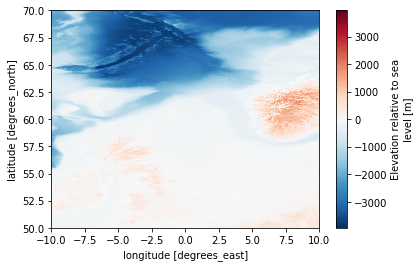

In [7]:
# plot the grid using xarray plot
subset.plot()

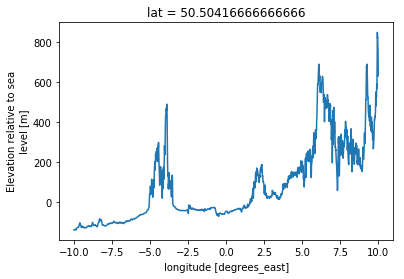

In [8]:
# plot a proflie across the grid at a given latitude
subset.isel(lat=60).plot.line()

In [9]:
# plot a proflie across the grid at a given latitude
subset.lon
# subset.isel(lon=-2.5).plot.line()

<xarray.DataArray 'lon' (lon: 2400)>
array([-9.995833, -9.9875  , -9.979167, ...,  9.979167,  9.9875  ,  9.995833])
Coordinates:
  * lon      (lon) float64 -9.996 -9.988 -9.979 -9.971 -9.963 -9.954 -9.946 ...
Attributes:
    standard_name:       longitude
    long_name:           longitude
    units:               degrees_east
    axis:                X
    sdn_parameter_urn:   SDN:P01::ALONZZ01
    sdn_parameter_name:  Longitude east
    sdn_uom_urn:         SDN:P06::DEGE
    sdn_uom_name:        Degrees east

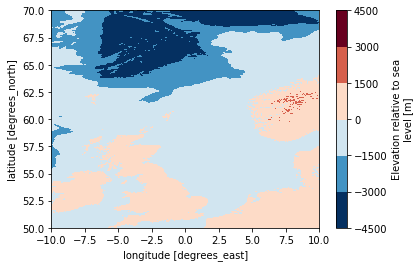

In [10]:
# plot with descrete palette levels or intervals
subset.plot(levels=8)

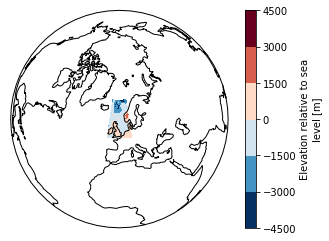

In [11]:
# plot on a globe
ax = plt.axes(projection=ccrs.Orthographic(-0, 60))
subset.plot.contourf(ax=ax, transform=ccrs.PlateCarree());
ax.set_global(); ax.coastlines();